In [8]:
#import pandas as pd
import tensorflow as tf
from matplotlib import pyplot
import numpy as np

# Setting up the Project

## Loading the Dataset

In [9]:
from keras.datasets import fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 1s 0us/step


## Preparing the Dataset

In [13]:
def load_dataset():
    (trainX, _), (_, _) = fashion_mnist.load_data()
    dataset = np.expand_dims(trainX, axis=-1)
    dataset = dataset.astype('float32')
    dataset = dataset / 255.0
    return dataset

In [14]:
def pick_samples(dataset, num_samples):
    rand_samples = randint(0, dataset.shape[0], num_samples)
    X = dataset[rand_samples]
    y = np.ones((num_samples, 1))
    return X, y

## Displaying the Dataset

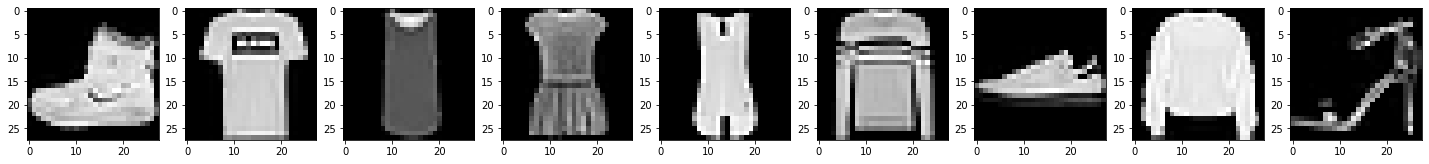

In [15]:
fig = pyplot.gcf()
fig.set_size_inches(25, 10.5)
fig.savefig('test2png.png', dpi=100)
x_train = load_dataset()

for i in range(9):
	pyplot.subplot(1,9,i + 1)
	pyplot.imshow(x_train[i],cmap=pyplot.get_cmap('gray'))
# show the figure
pyplot.show()

## Create Batches

In [16]:
train_images = tf.data.Dataset.from_tensor_slices(x_train).shuffle(len(x_train)).batch(256)

# Generating the GAN

In [17]:
from tensorflow.keras import layers

## Creating the Discriminator

The purpose of a discriminator in a GAN is to determine how realistic an image looks. To do this both the real images from the training set, and generated images from the generator are passed into this model. By doing this the model is able to learn how to predict the likelihood that an image is real or not. This feature is very important, because it allows us to make sure that our generator produces realistic images. 

This discriminator takes in a 28 x 28 x 1 image and at the end will ouput the probabillity that an image is real. 

In [18]:
def discriminator():
    # Defining the model 
    model = tf.keras.Sequential()

    # Input Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    # Hidden Layers
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Output Layer
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation="sigmoid"))

    # Define Optimization function
    opt = tf.keras.optimizers.Adam(lr=2e-4, beta_1=0.5)

    # Compile Model
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

## Creating the generator

The purpose of the generator is to generate data that could plausibly be from the original dataset. It's essentially trying to fool the discriminator. To do so, we will start with a vector, of latent_vecc_dim dimensions, that is instantiated with random values. The generator takes this vector and creates a set of low resolution images. We want it to be a set so the generator has space to combine values in multiple ways and learn from that.

Once that is done, the images are eventually upsampled to the target resolution 28 x 28.

In [19]:
def generator(latent_vec_dim):
    # Defining the model
    model = tf.keras.Sequential()
    
    # Input layer, takes in a vector with latent_dim dimensions 
    # and has enough nodes for multiple versions of low resolution
    # images. Picking a standard number like 128, we need 256x28x28 nodes.
    num_nodes = 256*28*28
    
    model.add(layers.Dense(num_nodes, input_dim = latent_vec_dim))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Reshape(7,7,128))
    
    # now upsample the low res 7x7 image to 14x14 image
    model.add(layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    # upsample to 28x28
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
    return model

## Creating the GAN

The GAN is a compound model consisting of the generator and then the discriminator in that order. The discriminator is not trainable in the GAN because we are targeting the generator, and having weights that change in the discriminator after every datapoint is not a viable way of training it. That being said the discriminator does get trained every epoch, just not here.

In [20]:
def gan(disc, gen):
    disc.trainable = false
    
    model = Sequential()
    model.add(gen)
    model.add(disc)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1 = 0.5)
    model.compile(loss='binary_crossentropy', optimizer=adam)
    return model